In [1]:

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn

import seaborn as sns

# special matplotlib argument for improved plots
from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("poster")
from sklearn.linear_model import LinearRegression
from sklearn.utils import shuffle
from IPython.core.display import HTML
import seaborn as sns
import re
from pandas import get_dummies
%matplotlib inline

css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

## Data Gathering and EDA

Importing the data into a **pandas Dataframe**

In [2]:
titles = pd.DataFrame.from_csv('movie_metadata.csv', index_col=None)

In [3]:
titles=titles.set_index('movie_title')

In [4]:
print(titles.columns)

Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'num_voted_users', 'cast_total_facebook_likes', 'actor_3_name',
       'facenumber_in_poster', 'plot_keywords', 'movie_imdb_link',
       'num_user_for_reviews', 'language', 'country', 'content_rating',
       'budget', 'title_year', 'actor_2_facebook_likes', 'imdb_score',
       'aspect_ratio', 'movie_facebook_likes'],
      dtype='object')


Creating a ratio field for profit percentage

In [5]:
titles['ratio']=titles.gross/titles.budget

In [6]:
titles=titles=titles.dropna(axis=0, subset=['imdb_score','gross', 'budget', 'ratio', 'director_facebook_likes' , 'content_rating' , 'title_year' , 'movie_facebook_likes' ])

Checking the distribution of **movie ratings**.  
Low frequency ratings are removed later to improve prediction accuracy.


In [7]:
titles.content_rating.value_counts()

R            1737
PG-13        1331
PG            576
G              91
Not Rated      42
Unrated        24
Approved       17
X              10
NC-17           6
Passed          3
M               2
GP              1
Name: content_rating, dtype: int64

**Analyzing `imdb` score disctribution**

In [8]:
((titles.imdb_score//1)).value_counts()

6.0    1459
7.0    1091
5.0     769
4.0     217
8.0     211
3.0      64
2.0      22
9.0       4
1.0       3
Name: imdb_score, dtype: int64

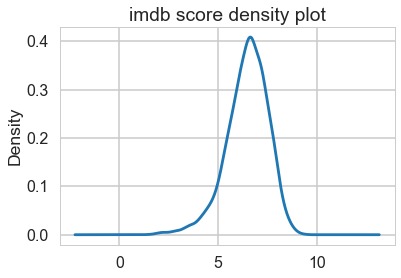

In [9]:
titles.imdb_score.plot.kde(title='imdb score density plot' )

In [10]:
titles.genres=titles.genres.str.replace("\|.*","")


**Analyzing Genre Distribution of the movies**

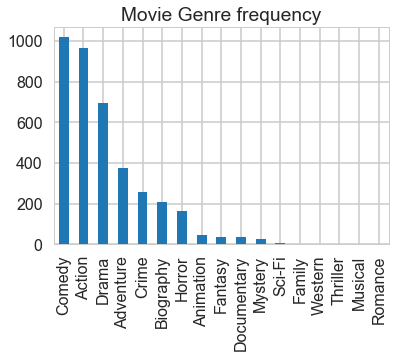

In [11]:
titles.genres.value_counts().plot(kind = 'bar', title='Movie Genre frequency')

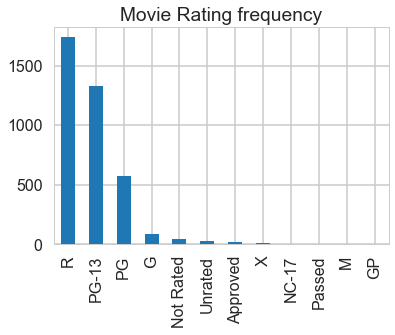

In [12]:
titles.content_rating.value_counts().plot(kind = 'bar', title='Movie Rating frequency')

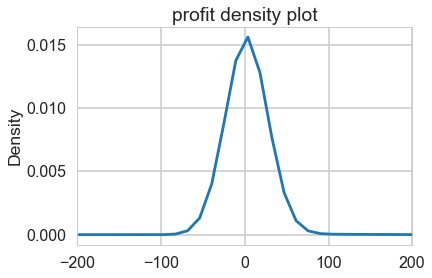

In [13]:
titles.ratio.plot.kde(xlim=[-200,200] , title='profit density plot')

** looking for outliers in profit ratio. To improve efficiency of the model **


In [14]:
(titles.ratio//100).value_counts()

0.0     3823
1.0        9
2.0        2
3.0        2
71.0       1
4.0        1
27.0       1
23.0       1
Name: ratio, dtype: int64

**removing movies with a very high profit ratio (>200x) for which are mostly low budget movies**

In [15]:
titles=titles.drop(titles[(titles.ratio>200)].index)

In [16]:
titles.ratio.mean() , titles.ratio.std() 


(2.7023612667579786, 8.60812467633687)

## Profit distribution
**Majority of movies make a loss**


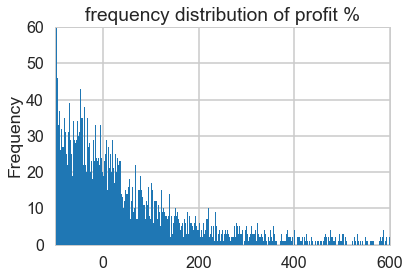

In [17]:
((titles.ratio -1 )*100).plot.hist(xlim=[-100,600],ylim=[0,60],bins=10000,title="frequency distribution of profit %")

In [18]:
titles.ratio.mean() , titles.ratio.std() , titles.ratio.median() 

(2.7023612667579786, 8.60812467633687, 1.081657044736842)

**Defining the criterion of a classifying a movie as profit making. 
Choosing a value well above the median:: `20%` profit**


In [19]:
titles['profit_making']= (titles.ratio > 1.2)

In [20]:
titles.profit_making.value_counts()

False    2059
True     1773
Name: profit_making, dtype: int64

In [21]:
#titles2 = pd.DataFrame.from_csv('movie_metadata.csv', index_col=None)

In [22]:
#(titles.budget/1e6).plot.hist(bins=10000,xlim=[0,1000],title="budget distribution millions $")


### Vital budget statistics in $ million

In [23]:
titles.budget.mean()/1e6 , titles.budget.std()/1e6 , titles.budget.median()/1e6


(45.56992900782881, 223.84992523867987, 25.0)

In [24]:
((titles.budget//1e7)).value_counts().sort_index()

0.0       920
1.0       698
2.0       535
3.0       391
4.0       258
5.0       215
6.0       174
7.0       120
8.0        93
9.0        60
10.0       69
11.0       32
12.0       37
13.0       34
14.0       26
15.0       45
16.0       15
17.0       24
18.0       11
19.0        7
20.0       28
21.0        5
22.0        7
23.0        2
24.0        1
25.0        9
26.0        2
30.0        2
39.0        1
40.0        1
55.0        1
70.0        2
100.0       1
110.0       1
212.0       1
240.0       1
250.0       1
420.0       1
1221.0      1
Name: budget, dtype: int64

#### Looks like there are a few outliers which will have to be filtered out later 
On further investigation these movies are not made in the USA and do not have thier budget statistics in USD.

In [25]:
titles[titles.budget>.33e9].country.value_counts()

Japan          4
South Korea    2
France         1
Thailand       1
Hungary        1
India          1
Spain          1
China          1
Name: country, dtype: int64

In [26]:
len(titles[titles.country != "USA"])

788

** Removing foreign movies from the Dataset. Maybe add currency conversion in the future**

In [27]:
titles=titles.drop(titles[titles.country != "USA"].index)

#### **Converting non quantitative data items (Genres, Ratings and color) into features**

In [28]:
titles=pd.get_dummies(titles , columns=["genres"])

In [29]:
titles.content_rating.value_counts()

R            1327
PG-13        1114
PG            474
G              71
Not Rated      19
Unrated        12
Approved        9
X               9
NC-17           4
Passed          3
M               1
Name: content_rating, dtype: int64

In [30]:
titles=pd.get_dummies(titles, columns=["color"])

** Removing low frequency ratings instances **

In [31]:
titles=titles.drop(titles[titles.content_rating.str.match("NC-17|Passed|M|GP")].index)

In [32]:
titles=pd.get_dummies(titles , columns=["content_rating"])

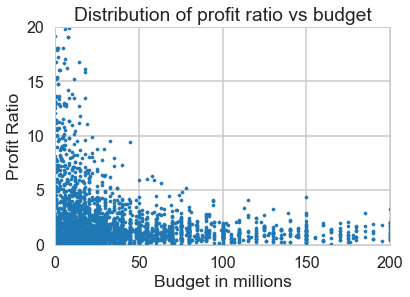

In [33]:
plt.axis([0,200,0,50])
plt.xlabel('Budget in millions')
plt.ylabel('Profit Ratio')
plt.title('Distribution of profit ratio vs budget')
plt.scatter(titles.budget/(1e6) , titles.ratio , s=10)
plt.axis([0,200,0,20])

plt.show()

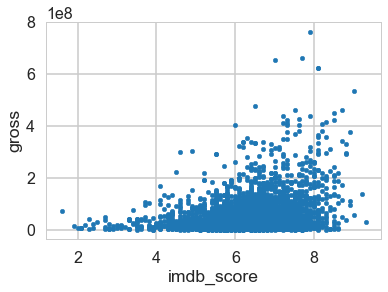

In [34]:
titles.plot.scatter(x='imdb_score',y='gross')

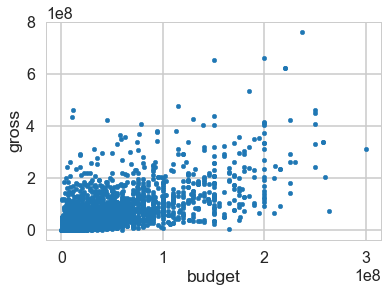

In [35]:
titles.plot.scatter(x='budget',y='gross')

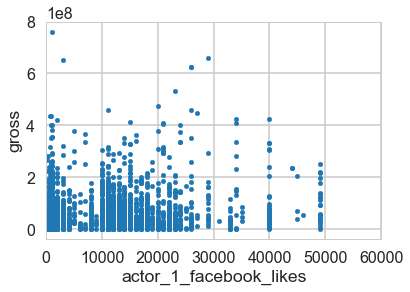

In [36]:
titles.plot.scatter(x='actor_1_facebook_likes',y='gross', xlim=[0,60000])

In [37]:
titles_non_normalized=titles

##  Sending budget and number of likes through normalizer


In [38]:
def normalize(array1, name):
    print ("normalizing "+name);
    array=array1
    array=array/array.std()
    array=array-array.mean()
    return(array);

In [39]:
for column in ['budget','movie_facebook_likes','cast_total_facebook_likes','director_facebook_likes','actor_1_facebook_likes','actor_2_facebook_likes','duration','num_voted_users', 'num_user_for_reviews', 'gross']:
    if np.issubdtype(titles[column].dtype, np.number):
        print (column + ": true")
        titles[column]=normalize(array1=titles[column],name=column)
    else:
        print (column + ":false")

budget: true
normalizing budget
movie_facebook_likes: true
normalizing movie_facebook_likes
cast_total_facebook_likes: true
normalizing cast_total_facebook_likes
director_facebook_likes: true
normalizing director_facebook_likes
actor_1_facebook_likes: true
normalizing actor_1_facebook_likes
actor_2_facebook_likes: true
normalizing actor_2_facebook_likes
duration: true
normalizing duration
num_voted_users: true
normalizing num_voted_users
num_user_for_reviews: true
normalizing num_user_for_reviews
gross: true
normalizing gross


In [40]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.
        Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    plt.figure(figsize=(10,10) , dpi= 300)
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90);
    plt.yticks(range(len(corr.columns)), corr.columns);

In [41]:
list1=[]
for x in titles.columns:
    if re.match('(content)|(genre)|(color)',x):
        list1.append(x)

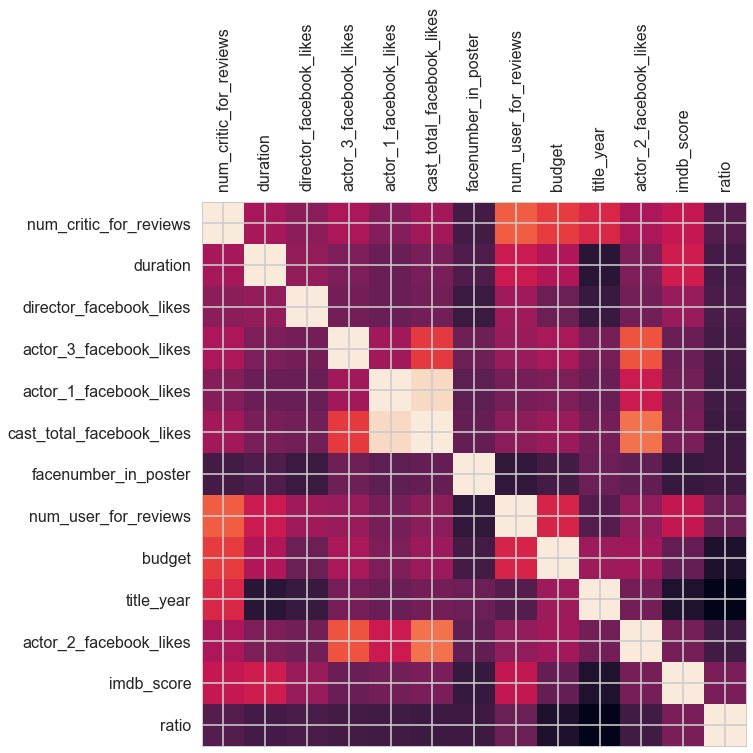

In [42]:
titles_correlation=titles.drop([ 'profit_making','movie_facebook_likes','num_voted_users','gross','aspect_ratio'],axis=1 )

titles_correlation=titles_correlation.drop(list1,axis=1)

plot_corr(titles_correlation)

In [43]:
titles_correlation.corr().filter(['ratio','cast_total_facebook_likes','duration'])

,ratio,cast_total_facebook_likes,duration
num_critic_for_reviews,0.023809,0.252788,0.269825
duration,-0.021709,0.133333,1.000000
director_facebook_likes,-0.001804,0.116920,0.209395
actor_3_facebook_likes,-0.026360,0.482528,0.143701
actor_1_facebook_likes,-0.039214,0.945888,0.089803
cast_total_facebook_likes,-0.046234,1.000000,0.133333
facenumber_in_poster,-0.043795,0.075342,0.005242
num_user_for_reviews,0.092855,0.189405,0.376825
budget,-0.149816,0.234009,0.299387
title_year,-0.250859,0.123287,-0.113718


#### Couple of points to evaluate
Light color is positive correlation; Dark color is negative correlation
   1. year of release shows a very strong negative correlation with the success of the movie: **This needs to be evaluated further. **
   2. Imdb score shows a positive correlation which is expected
   3. Things like facebook likes show a slight negative correlation with the success of movies; whichis kindof counter intutive. 
   4. Feature like cast_total_facebook_likes and actor_1_facebook likes are very positively correlated hence one of them could be easily removed


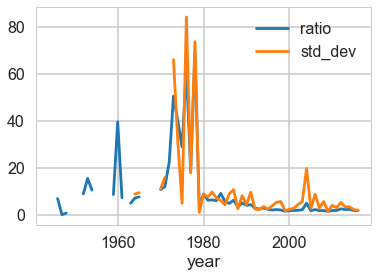

In [44]:
ratio_list=[]
for i in range(1940, 2020):
    ratio_mean=titles_correlation[(titles_correlation.title_year==i)].ratio.mean()
    ratio_std=titles_correlation[(titles_correlation.title_year==i)].ratio.std()
    ratio_list.append([i,((ratio_mean//.1)/10),((ratio_std//.1)/10)])
ratio_data_frame=pd.DataFrame(ratio_list)
ratio_data_frame=ratio_data_frame.set_index(0)
ratio_data_frame.columns=['ratio','std_dev']
ratio_data_frame.index.name='year'
ratio_data_frame[ratio_data_frame.index > 1940].plot.line()

#### As we can the see the variability reduces quite a bit after 1980's thats due to lack of large number of instances pre 1980. 
#### So Maybe the prediction accuracy will improve if we use post-1980 movies in our training data. 

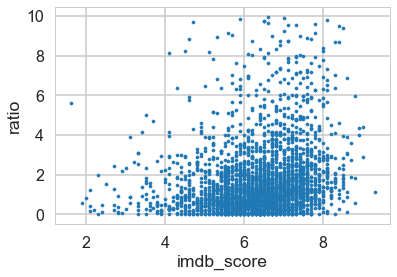

In [45]:
titles[(titles.ratio<10)].plot.scatter(x='imdb_score',y='ratio', s=10)

#### Removing IMDB score since it is unknown before a movie get released also removing movies before 1980  

In [46]:
##titles=titles.drop(titles[(titles.title_year < 1980)].index)
titles=titles.drop(['imdb_score'], axis=1)

## Splitting titles into low budget and high budget movies

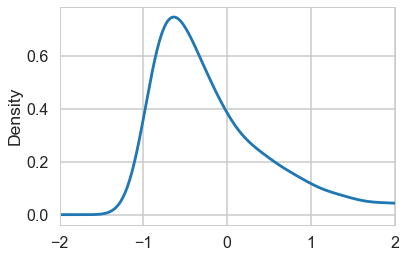

In [47]:
titles.budget.plot.kde(xlim=[-2,2])

In [48]:
titles.budget.median() 

-0.35378772592239804

In [49]:
titles.ratio.mean()

2.9149714718665765

#### Profit Distribution between low and high budget movies was found to be quite different. So splitting them will be benificial from a point of view of accurately training the predictors
#### Taking the median as roughly the point that splits the high budget and low budget movies 

In [50]:
titles_highb = titles[(titles.budget > titles.budget.median() )]

In [51]:
titles_lowb = titles[(titles.budget <= titles.budget.median() )]

In [52]:
len(titles_highb)

1508

In [53]:
 len(titles_lowb)

1527

#### The Graph shows the wide variation in distribution of profit making between high and low budget movies

<Container object of 13 artists>

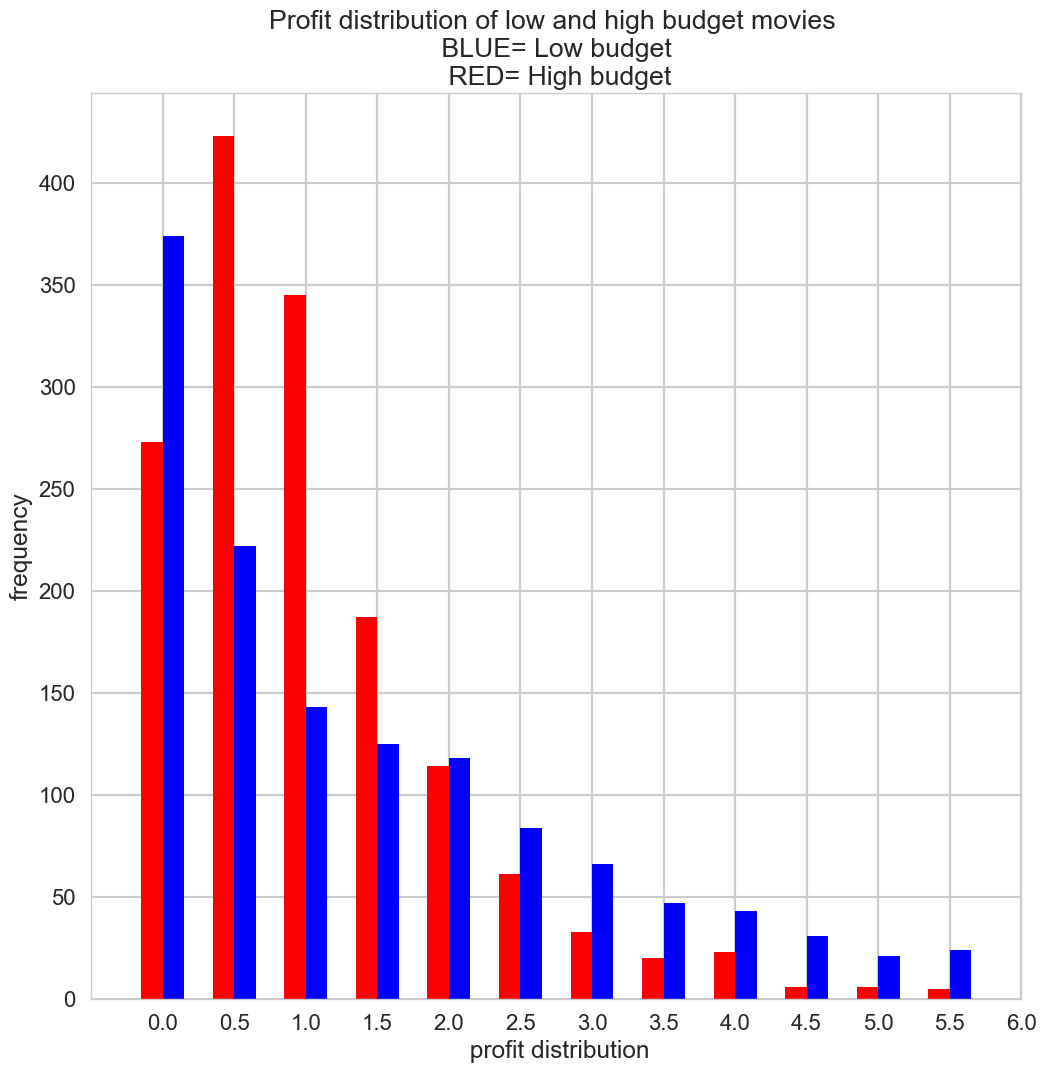

In [54]:
temp=((titles_highb.ratio//.5)*.5).value_counts()
temp=temp.sort_index(ascending=True)
temp2=((titles_lowb.ratio//.5)*.5).value_counts()
temp2=temp2.sort_index(ascending=True)

plt.figure(figsize=(12,12), dpi=100)
plt.title("Profit distribution of low and high budget movies \n BLUE= Low budget \n RED= High budget")
plt.yticks([0,50,100,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900])
plt.xticks([0,.50,1.00,1.50,2.00,2.50,3.00,3.50,4.00,4.50,5.00,5.50,6.00])

plt.xlim(-.5,6)
plt.xlabel(' profit distribution')
plt.ylabel('frequency')
#plt.hist([temp], color=['RED'] , rwidth=.5)
temp=(((titles_highb[titles_highb.ratio<6.1].ratio)//.5)*.5).value_counts().sort_index()
temp2=(((titles_lowb[titles_lowb.ratio<6.1].ratio)//.5)*.5).value_counts().sort_index()

plt.bar(x=temp.index,height=temp.values,width=-.15 , color=['RED'] , align='edge')
plt.bar(x=temp2.index,height=temp2.values,width=+.15 , color=['BLUE'] , align='edge')

#plt.hist([(((titles_highb[titles_highb.ratio<6.1].ratio)//.5)*.5),(((titles_lowb[titles_lowb.ratio<6.1].ratio)//.5)*.5)], color=['RED','BLUE'])

In [55]:
titles_highb.profit_making.mean()

0.43236074270557029

In [56]:
titles_lowb.profit_making.mean()

0.57301899148657498

## Classification

In [57]:
titles_cat_ml_highb=titles_highb.select_dtypes(exclude=['object']) 

titles_cat_ml_highb_ratio=titles_cat_ml_highb.ratio

titles_cat_logistic_highb=titles_cat_ml_highb.drop(['ratio'], axis=1)

titles_cat_logistic_highb=titles_cat_logistic_highb.dropna()

titles_cat_logistic_highb=shuffle(titles_cat_logistic_highb)

titles_cat_logistic_highb_train=titles_cat_logistic_highb[:round((len(titles_cat_logistic_highb)*.7))]
titles_cat_logistic_highb_test=titles_cat_logistic_highb[round((len(titles_cat_logistic_highb)*.7)):]

In [58]:
titles_cat_logistic_highb_train_x=titles_cat_logistic_highb_train.drop(['gross', 'profit_making','movie_facebook_likes','num_voted_users'],axis=1 )

titles_cat_logistic_highb_test_x=titles_cat_logistic_highb_test.drop( ['gross', 'profit_making','movie_facebook_likes','num_voted_users' ],axis=1)

titles_cat_logistic_highb_train_y=pd.DataFrame(titles_cat_logistic_highb_train['profit_making'])

titles_cat_logistic_highb_test_y=pd.DataFrame(titles_cat_logistic_highb_test[ 'profit_making' ])

In [59]:

titles_cat_ml_lowb=titles_lowb.select_dtypes(exclude=['object']) 

titles_cat_ml_lowb_ratio=titles_cat_ml_lowb.ratio

titles_cat_logistic_lowb=titles_cat_ml_lowb.drop(['ratio'], axis=1)

titles_cat_logistic_lowb=titles_cat_logistic_lowb.dropna()

titles_cat_logistic_lowb=shuffle(titles_cat_logistic_lowb)

titles_cat_logistic_lowb_train=titles_cat_logistic_lowb[:round((len(titles_cat_logistic_lowb)*.7))]
titles_cat_logistic_lowb_test=titles_cat_logistic_lowb[round((len(titles_cat_logistic_lowb)*.7)):]

In [60]:
titles_cat_logistic_lowb_train_x=titles_cat_logistic_lowb_train.drop(['gross', 'profit_making','movie_facebook_likes','num_voted_users'],axis=1 )

titles_cat_logistic_lowb_test_x=titles_cat_logistic_lowb_test.drop( ['gross', 'profit_making','movie_facebook_likes','num_voted_users' ],axis=1)

titles_cat_logistic_lowb_train_y=pd.DataFrame(titles_cat_logistic_lowb_train['profit_making'])

titles_cat_logistic_lowb_test_y=pd.DataFrame(titles_cat_logistic_lowb_test[ 'profit_making' ])

In [61]:
len(titles_cat_logistic_lowb) , len(titles_cat_logistic_lowb_train) , len(titles_cat_logistic_lowb_test)

(1474, 1032, 442)

In [62]:
len(titles_cat_logistic_highb) , len(titles_cat_logistic_highb_train) , len(titles_cat_logistic_highb_test)

(1505, 1054, 451)

#### Variable for tracking accuracy score

In [63]:
array_accuracy_score={}
array_accuracy_score['high_b'] = {}
array_accuracy_score['low_b'] = {}

## `Logistic Regression `

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler


In [65]:
logistic_regression_1= LogisticRegression()
logistic_regression_1.fit(titles_cat_logistic_highb_train_x,titles_cat_logistic_highb_train_y.profit_making)
accuracy_score(logistic_regression_1.predict(titles_cat_logistic_highb_test_x),titles_cat_logistic_highb_test_y.profit_making)

0.68736141906873616

In [66]:
logistic_regression_2= LogisticRegression()
logistic_regression_2.fit(titles_cat_logistic_lowb_train_x,titles_cat_logistic_lowb_train_y.profit_making)
accuracy_score(logistic_regression_2.predict(titles_cat_logistic_lowb_test_x),titles_cat_logistic_lowb_test_y.profit_making)

0.67647058823529416

In [67]:
y=titles_cat_logistic_lowb_test_y.reset_index()
y=y.drop('movie_title', axis=1)

x=titles_cat_logistic_lowb_test_x.reset_index()
x=x.drop('movie_title', axis=1)

In [68]:
logistic_regression_nocross= LogisticRegression()
logistic_regression_nocross.fit(titles_cat_logistic_highb_train_x,titles_cat_logistic_highb_train_y.profit_making)
accuracy_score(logistic_regression_nocross.predict(titles_cat_logistic_highb_test_x),titles_cat_logistic_highb_test_y.profit_making)

0.68514412416851445

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(nfold).split(x): # split data into train/test groups, 5 times
        clf.fit(x.loc[train], y.loc[train]) # fit
        result += accuracy_score(clf.predict(x.loc[test]), y.loc[test]) # evaluate score function on held-out data
    return result / nfold # average

In [70]:
score=0
Cs = [0.001, .01, 0.1, 1,  10, 100, 1000]
C_val=0
for i in Cs:
    clf = LogisticRegression(C=i)
    if (score < cv_score(clf, x, y)):
        score=cv_score(clf, x, y)
        C_val=i
        score_val=score

print(score_val,C_val)


/Users/mrkulkarni1/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.649514811032 10


In [71]:
logiastic_regression_1= LogisticRegression(C=C_val)
logistic_regression_1.fit(titles_cat_logistic_highb_train_x,titles_cat_logistic_highb_train_y.profit_making)
accuracy_score(logistic_regression_1.predict(titles_cat_logistic_highb_test_x),titles_cat_logistic_highb_test_y.profit_making)

0.68514412416851445

In [72]:
logistic_regression_2= LogisticRegression(C=C_val)
logistic_regression_2.fit(titles_cat_logistic_lowb_train_x,titles_cat_logistic_lowb_train_y.profit_making)
accuracy_score(logistic_regression_2.predict(titles_cat_logistic_lowb_test_x),titles_cat_logistic_lowb_test_y.profit_making)

0.66063348416289591

In [73]:
array_accuracy_score['high_b']['lr'] = logistic_regression_1.score(titles_cat_logistic_highb_test_x,titles_cat_logistic_highb_test_y.profit_making)
array_accuracy_score['low_b']['lr']=logistic_regression_2.score(titles_cat_logistic_lowb_test_x,titles_cat_logistic_lowb_test_y.profit_making)

## `Logistic Regression with standard scalar`

In [74]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

lgr = Pipeline([
        ("scaler", StandardScaler()),
        ("lgr_clf", LogisticRegression(C=.1))
])

In [75]:
lgr.fit(titles_cat_logistic_lowb_train_x,titles_cat_logistic_lowb_train_y.profit_making)
lgr.score(titles_cat_logistic_lowb_test_x,titles_cat_logistic_lowb_test_y.profit_making)

0.70814479638009054

In [76]:
lgr2 = Pipeline([
        ("scaler", StandardScaler()),
        ("lgr_clf", LogisticRegression(C=.1))
])
lgr2.fit(titles_cat_logistic_highb_train_x,titles_cat_logistic_highb_train_y.profit_making)
lgr2.score(titles_cat_logistic_highb_test_x,titles_cat_logistic_highb_test_y.profit_making)

0.69844789356984482

## `Support Vector Machine`

In [77]:
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.svm import LinearSVC


In [78]:
poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly"))
])


In [79]:
poly_kernel_svm_clf.fit(titles_cat_logistic_lowb_train_x,titles_cat_logistic_lowb_train_y.profit_making)
poly_kernel_svm_clf.score(titles_cat_logistic_lowb_train_x,titles_cat_logistic_lowb_train_y.profit_making)
poly_kernel_svm_clf.score(titles_cat_logistic_lowb_test_x,titles_cat_logistic_lowb_test_y.profit_making)

0.5678733031674208

In [80]:
x=titles_cat_logistic_lowb_train_x.reset_index() 
x=x.drop('movie_title', axis=1)
y=titles_cat_logistic_lowb_train_y.reset_index()
y=y.drop('movie_title', axis=1)

In [81]:
poly_kernel_svm_clf_cross = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=10, C=1))
])


In [82]:
from sklearn.model_selection import GridSearchCV


In [83]:
param_grid = [{'svm_clf__degree': [1,2,3] , 'svm_clf__C':[.1,1,10,100]},]
clf = poly_kernel_svm_clf_cross
grid_search=GridSearchCV(clf,param_grid,cv=5)
grid_search.fit(titles_cat_logistic_lowb_train_x,titles_cat_logistic_lowb_train_y.profit_making)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=1, cache_size=200, class_weight=None, coef0=10,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'svm_clf__degree': [1, 2, 3], 'svm_clf__C': [0.1, 1, 10, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [84]:
grid_search.score(titles_cat_logistic_lowb_test_x,titles_cat_logistic_lowb_test_y.profit_making)

0.70135746606334837

In [85]:
sklearn.metrics.confusion_matrix(titles_cat_logistic_lowb_test_y,grid_search.predict(titles_cat_logistic_lowb_test_x))

array([[138,  58],
       [ 74, 172]])

In [86]:
array_accuracy_score['low_b']['svm']=grid_search.score(titles_cat_logistic_lowb_test_x,titles_cat_logistic_lowb_test_y.profit_making)

#### High budget movie classification

In [87]:
clf_2 = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel='poly', coef0=10, C=1, degree=2))
])
param_grid = [{'svm_clf__degree': [1,2,3] , 'svm_clf__C':[.1,1,10,100]},]
grid_search_2=GridSearchCV(clf_2,param_grid,cv=5)
grid_search_2.fit(titles_cat_logistic_highb_train_x,titles_cat_logistic_highb_train_y.profit_making)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=1, cache_size=200, class_weight=None, coef0=10,
  decision_function_shape='ovr', degree=2, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'svm_clf__degree': [1, 2, 3], 'svm_clf__C': [0.1, 1, 10, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [88]:
grid_search_2.best_params_

{'svm_clf__C': 100, 'svm_clf__degree': 2}

In [89]:
grid_search_2.score(titles_cat_logistic_highb_test_x,titles_cat_logistic_highb_test_y.profit_making)

0.64079822616407978

In [90]:
sklearn.metrics.confusion_matrix(titles_cat_logistic_highb_test_y,grid_search_2.predict(titles_cat_logistic_highb_test_x))

array([[202,  51],
       [111,  87]])

In [91]:
array_accuracy_score['high_b']['svm']=grid_search_2.score(titles_cat_logistic_highb_test_x,titles_cat_logistic_highb_test_y.profit_making)

## `Random forest` 

In [92]:
from sklearn.ensemble import RandomForestClassifier

In [93]:
rnd_clf = RandomForestClassifier()
rnd_clf.fit(titles_cat_logistic_lowb_train_x,titles_cat_logistic_lowb_train_y.profit_making)
rnd_clf.score(titles_cat_logistic_lowb_test_x,titles_cat_logistic_lowb_test_y.profit_making)

0.64253393665158376

In [94]:
x=titles_cat_logistic_lowb_train_x.reset_index() 
x=x.drop('movie_title', axis=1)
y=titles_cat_logistic_lowb_train_y.reset_index()
y=y.drop('movie_title', axis=1)

In [95]:
import warnings
warnings.filterwarnings('ignore')

score=0
m= [10,100,1000]
n= [100,1000,10000]
#kernel=['linear','rbf','poly']
max_nodes_final,n_estim_fianl=0,0

for max_nodes in m:
    for n_estim in n:
        clf = RandomForestClassifier(n_estimators=n_estim, max_leaf_nodes=max_nodes, n_jobs=-1, random_state=42)
        if (score < cv_score(clf, x, y)):
            score=cv_score(clf, x, y)
            score_val=score
            max_nodes_final=max_nodes
            n_estim_fianl=n_estim
            print(score_val,max_nodes,n_estim)
        

print(score_val,max_nodes_final,n_estim_fianl)


0.699591951597 10 100
0.705374982412 10 1000
0.709281928615 100 1000
0.714126917124 100 10000
0.714126917124 100 10000


In [96]:
rnd_clf = RandomForestClassifier(n_estimators=n_estim_fianl, max_leaf_nodes=max_nodes_final, n_jobs=-1, random_state=42)
rnd_clf.fit(titles_cat_logistic_lowb_train_x,titles_cat_logistic_lowb_train_y.profit_making)
rnd_clf.score(titles_cat_logistic_lowb_test_x,titles_cat_logistic_lowb_test_y.profit_making)

0.70588235294117652

In [97]:
sklearn.metrics.confusion_matrix(titles_cat_logistic_lowb_test_y,rnd_clf.predict(titles_cat_logistic_lowb_test_x))

array([[111,  85],
       [ 45, 201]])

In [98]:
array_accuracy_score['low_b']['rnd']=rnd_clf.score(titles_cat_logistic_lowb_test_x,titles_cat_logistic_lowb_test_y.profit_making)

In [99]:
x=titles_cat_logistic_highb_train_x.reset_index() 
x=x.drop('movie_title', axis=1)
y=titles_cat_logistic_highb_train_y.reset_index()
y=y.drop('movie_title', axis=1)

In [100]:
import warnings
warnings.filterwarnings('ignore')
score=0
m= [10,100,1000]
n= [100,1000,10000]
#kernel=['linear','rbf','poly']
max_nodes_final,n_estim_fianl=0,0

for max_nodes in m:
    for n_estim in n:
        clf = RandomForestClassifier(n_estimators=n_estim, max_leaf_nodes=max_nodes, n_jobs=-1, random_state=42)
        if (score < cv_score(clf, x, y)):
            score=cv_score(clf, x, y)
            score_val=score
            max_nodes_final=max_nodes
            n_estim_fianl=n_estim
            print(score_val,max_nodes,n_estim) 

print(score_val,max_nodes_final,n_estim_fianl)   

0.655572105619 10 100
0.689713382984 100 100
0.694470774092 1000 1000
0.694470774092 1000 1000


In [101]:
rnd_clf2 = RandomForestClassifier(n_estimators=n_estim_fianl, max_leaf_nodes=max_nodes_final, n_jobs=-1, random_state=42)
rnd_clf2.fit(titles_cat_logistic_highb_train_x,titles_cat_logistic_highb_train_y.profit_making)
rnd_clf2.score(titles_cat_logistic_highb_test_x,titles_cat_logistic_highb_test_y.profit_making)

0.69179600886917958

In [102]:
sklearn.metrics.confusion_matrix(titles_cat_logistic_highb_test_y,rnd_clf2.predict(titles_cat_logistic_highb_test_x))

array([[207,  46],
       [ 93, 105]])

In [103]:
rnd = RandomForestClassifier(n_estimators=10, max_leaf_nodes=10, n_jobs=-1, random_state=42)

In [104]:
param_grid_rnd = [{'n_estimators': [100,1000,10000] , 'max_leaf_nodes':[100,1000,10000]},]
grid_search_rnd=GridSearchCV(rnd,param_grid_rnd,cv=5)
grid_search_rnd.fit(titles_cat_logistic_highb_train_x,titles_cat_logistic_highb_train_y.profit_making)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=10,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [100, 1000, 10000], 'max_leaf_nodes': [100, 1000, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [105]:
grid_search_rnd.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=1000,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [106]:
grid_search_rnd.score(titles_cat_logistic_highb_test_x,titles_cat_logistic_highb_test_y.profit_making)

0.68070953436807091

In [107]:
sklearn.metrics.confusion_matrix(titles_cat_logistic_highb_test_y,grid_search_rnd.predict(titles_cat_logistic_highb_test_x))

array([[203,  50],
       [ 94, 104]])

In [108]:
array_accuracy_score['high_b']['rnd']=grid_search_rnd.score(titles_cat_logistic_highb_test_x,titles_cat_logistic_highb_test_y.profit_making)

## `Voting Classifier`

In [109]:
from sklearn.ensemble import VotingClassifier


In [110]:
voting_clf = VotingClassifier(
       estimators=[('lr',lgr ),  ('svc', poly_kernel_svm_clf),  ('rnd', rnd_clf)],    voting='hard')

voting_clf_2 = VotingClassifier (
       estimators=[('lr',lgr2 ),  ('svc', grid_search_2),  ('rnd', rnd_clf2)],voting='hard')
#voting_clf.fit(X_train, y_train) '''


In [111]:
voting_clf.fit(titles_cat_logistic_lowb_train_x,titles_cat_logistic_lowb_train_y.profit_making )
voting_clf.score(titles_cat_logistic_lowb_test_x,titles_cat_logistic_lowb_test_y.profit_making)

0.7036199095022625

In [112]:
sklearn.metrics.confusion_matrix(titles_cat_logistic_lowb_test_y,voting_clf.predict(titles_cat_logistic_lowb_test_x))

array([[102,  94],
       [ 37, 209]])

In [113]:
array_accuracy_score['low_b']['voting']=voting_clf.score(titles_cat_logistic_lowb_test_x,titles_cat_logistic_lowb_test_y.profit_making)

In [114]:
voting_clf_2.fit(titles_cat_logistic_highb_train_x,titles_cat_logistic_highb_train_y.profit_making )
voting_clf_2.score(titles_cat_logistic_highb_test_x,titles_cat_logistic_highb_test_y.profit_making)

0.70066518847006654

In [115]:
sklearn.metrics.confusion_matrix(titles_cat_logistic_highb_test_y,voting_clf_2.predict(titles_cat_logistic_highb_test_x))

array([[219,  34],
       [101,  97]])

In [116]:
array_accuracy_score['high_b']['voting']=voting_clf_2.score(titles_cat_logistic_highb_test_x,titles_cat_logistic_highb_test_y.profit_making)

## Summarizing prediction accuracies

In [117]:
a1,b1=zip(*sorted(array_accuracy_score['high_b'].items()))
a2,b2=zip(*sorted(array_accuracy_score['low_b'].items()))
a1,a2,b1,b2 = np.array(a1),np.array(a2),np.array(b1),np.array(b2)
b3=(b1+b2)/2

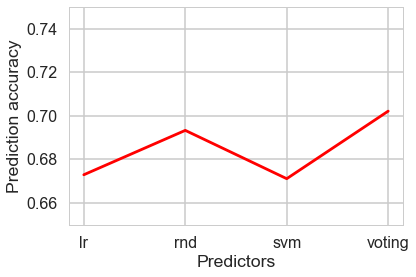

In [118]:
plt.ylabel('Prediction accuracy')
plt.xlabel('Predictors')
plt.ylim(.65,.75)
plt.plot(a1,b3 , '-',color='RED')
#plt.plot(a2,b2 , '-',color='BLUE')

## `Feature weights`

In [119]:
x=pd.DataFrame(rnd_clf.feature_importances_)

In [120]:
x=x.rename(columns={0:"weight"})

In [121]:
x['features']=pd.DataFrame(titles_cat_logistic_lowb_train_x.columns.values)

In [122]:
x.sort_values('weight' , ascending=False).head()

,weight,features
7,0.181949,num_user_for_reviews
0,0.106905,num_critic_for_reviews
9,0.095192,title_year
8,0.074209,budget
1,0.066968,duration
